In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Arabas_et_al_2015 import Settings, SpinUp
from PySDM_examples.Szumowski_et_al_1998 import Simulation, Storage
from PySDM.exporters import NetCDFExporter
from PySDM_examples.utils import ProgBarController
from open_atmos_jupyter_utils import show_plot, TemporaryFile
from PySDM_examples.Bartman_et_al_2021.label import label
import PySDM.products as PySDM_products
from PySDM.physics import si
import matplotlib
import numpy as np
import string
import os
from scipy.io.netcdf import netcdf_file
from matplotlib import pyplot
from scipy.ndimage.filters import uniform_filter1d

In [3]:
tol = .5e-6
m = 2
runs = (
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': True, 'condensation_rtol_thd': tol}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': True, 'condensation_rtol_thd': tol*m}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': True, 'condensation_rtol_thd': tol*m*m}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': True, 'condensation_rtol_thd': tol*m*m*m}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps': 128}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':  32}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':   8}},
    {'file': TemporaryFile('.nc'), 'settings': {'condensation_adaptive': False, 'condensation_substeps':   2}},
)

In [4]:
radius_range = (.5*si.um, 25*si.um)
dt = 32 * si.s

for i, run in enumerate(runs):
    settings = Settings()

    products = (
        PySDM_products.PeakSupersaturation(name='S_max', unit='%'),
        PySDM_products.DynamicWallTime('Condensation', name='Condensation_wall_time'),
        PySDM_products.ParticleSpecificConcentration(radius_range=(0, radius_range[0]), name='n_a_mg', unit='mg^-1'),
        PySDM_products.EffectiveRadius(radius_range=radius_range, name='r_eff', unit='um'),
        PySDM_products.CondensationTimestepMin(name='dt_cond_min')
    )

    settings.n_sd_per_gridbox = 128
    settings.grid = (32, 32)
    settings.dt = dt
    settings.condensation_dt_cond_range = (.125*si.s, settings.dt)
    
    settings.mode_1.norm_factor *= 3
    settings.mode_2.norm_factor *= 3
    settings.spectrum_per_mass_of_dry_air.norm_factor *= 3
    settings.simulation_time = settings.spin_up_time * (1 if 'CI' not in os.environ else .1)
    settings.output_interval = settings.dt
    settings.condensation_rtol_x = 1e-6
    settings.condensation_rtol_thd = -1
    settings.condensation_schedule = 'dynamic'
    settings.kappa = .8
    
    for key, value in run['settings'].items():        
        assert hasattr(settings, key)
        setattr(settings, key, value)
    
    storage = Storage()
    simulation = Simulation(settings, storage, SpinUp=SpinUp)
    simulation.reinit(products)

    simulation.run(ProgBarController(f"run {i+1}/{len(runs)}"))
    exporter = NetCDFExporter(storage, settings, simulation, run['file'].absolute_path)
    exporter.run(ProgBarController('netCDF'))

FloatProgress(value=0.0, description='run 1/8', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 2/8', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 3/8', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 4/8', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 5/8', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 6/8', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 7/8', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

FloatProgress(value=0.0, description='run 8/8', max=1.0)

FloatProgress(value=0.0, description='netCDF', max=1.0)

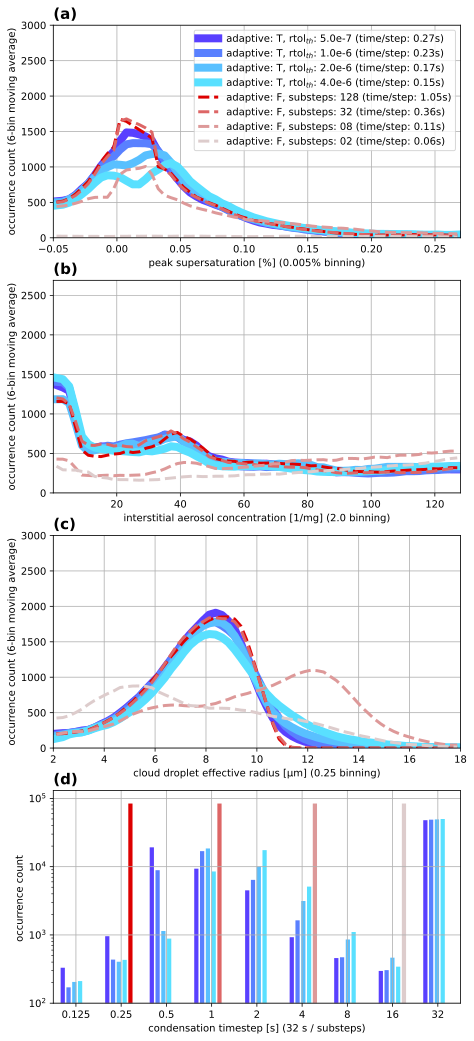

HTML(value="<a href='./tmp3wtu2h40.pdf' target='_blank'>./tmp3wtu2h40.pdf</a><br>")

In [5]:
matplotlib.rcParams["figure.figsize"] = (7.3, 18)

colors = (
    '#5940ff', '#5980ff', '#59c0ff', '#59e0ff',
    '#dd0000', '#dd6666', '#dd9999', '#ddcccc'
)
skip_steps = 30
bins = 64
bin_range = {
    'S_max': (-.05, .27),
    'n_a_mg': (0.05, 128.05),
    'r_eff': (2, 18),
    'dt_cond_min': (-3.5, 5.5)
}
window = 6

fig, axs = pyplot.subplots(len(bin_range),1)
for plot_i, var in enumerate(bin_range.keys()):
    ax = axs[plot_i]
    for i, run in enumerate(runs):
        nc = netcdf_file(run['file'].absolute_path, mode='r', mmap=False)
        n_spinup = nc.n_spin_up // nc.steps_per_output_interval
        assert skip_steps >= n_spinup // 4
        data = nc.variables[var]
        if var == 'dt_cond_min':
            data = np.log2(data[:])
        timesteps = slice(skip_steps, -1)
        wall_time = np.nanmean(nc.variables['Condensation_wall_time'][timesteps])
        wall_time = np.nan if not np.isfinite(wall_time) else int(100 * wall_time) / 100
        y, x, _ = ax.hist(data[timesteps, :, :].flatten(), 
                              bins=bins, range=bin_range[var], histtype='step', 
                              color=colors[i], lw=0)
        if var != 'dt_cond_min':
            filt_x = x[:-1] if window % 2 == 0 else (x[1:] + x[:-1])/2
            ax.plot(filt_x, uniform_filter1d(y, size=window), color=colors[i],
                        lw=8 if run['settings']['condensation_adaptive'] else 3,
                        ls='--' if not run['settings']['condensation_adaptive'] else '-',
                        label=f"{label(run['settings'])} (time/step: {wall_time:.2f}s)"
                   )
        else:
            dx = x[1] - x[0]
            ax.bar(x[0:-1] - dx/.66 + dx/1.1*min(4,i), y, color=colors[i], width=dx/1.5)
        ax.set_ylabel('occurrence count ' + (f'({window}-bin moving average)' if var != 'dt_cond_min' else ''))
        binwidth = (bin_range[var][1]-bin_range[var][0])/bins
        if var == 'S_max':
            ax.set_ylim(0, 3000)
            ax.set_xlabel(f'peak supersaturation [%] ({binwidth}% binning)')
        elif var == 'n_a_mg':
            ax.set_xlabel(f'interstitial aerosol concentration [1/mg] ({binwidth} binning)')
        elif var == 'r_eff':
            ax.set_xlabel(f'cloud droplet effective radius [μm] ({binwidth} binning)')
            ax.set_ylim(0, 3000)
        elif var == 'dt_cond_min':
            ax.set_xlabel(f'condensation timestep [s] ({dt:.0f} s / substeps)')
            labels = {pw:2**pw for pw in range(-3, 6)}
            ax.set_xticks(tuple(labels.keys()))
            ax.set_xticklabels(tuple(labels.values()))
            ax.set_yscale('log')
            ax.set_ylim(1e2, 1.3e5)
        else:
            assert False
    ax.grid()
    if plot_i == 0:
        ax.legend()
    ax.set_xlim(bin_range[var])
    ax.text(0, 1.03, '('+string.ascii_lowercase[plot_i]+')', transform=ax.transAxes, size=15, weight='bold')
show_plot()

In [6]:
# TODO #449: updraft vs. downdraft?
# TODO #449: different n_sd
# TODO #449: different aerosol
# TODO #449: schedule
# TODO #449: different initialisation